In [1]:
# notebook last tested with abtem version 1.0.0beta7

from abtem import __version__
print('current version:', __version__)

from ase import build
import matplotlib.pyplot as plt

import numpy as np
from abtem import *

# fft cache disabled for large simulations
from cupy.fft.config import get_plan_cache
cache = get_plan_cache()
cache.set_size(0)

current version: 1.0.0beta12


# Large CBED simulation

- 8.1 million atoms 
- 10000 potential slices
- 4096 x 4096 grid

- simulation time: 3 min per frozen phonon configuration on a NVidia RTX 2080 Ti

In [2]:
silicon = build.bulk('Si', crystalstructure='diamond', cubic=True)
silicon *= (74,74,185)

In [3]:
silicon.cell, len(silicon)

(Cell([401.82, 401.82, 1004.55]), 8104480)

In [4]:
# to simulate tds increase the number of frozen phonon configurations and set the sigma of the atomic vibrations

fp = FrozenPhonons(silicon, 
                   1, 
                   {'Si': 0.0}, 
                   seed=13, 
                   directions='xyz')

potential = Potential(fp,
                      gpts=4096, 
                      device='gpu',
                      storage='gpu', 
                      projection='infinite',
                      precalculate=False,
                      slice_thickness=.1,
                      parametrization='kirkland')

In [5]:
probe = Probe(energy=100e3, device='gpu', semiangle_cutoff=9.4)

probe.grid.match(potential)

wave = probe.build((0,0))

(<AxesSubplot:xlabel='x [Å]'>, <matplotlib.lines.Line2D at 0x26a62846310>)

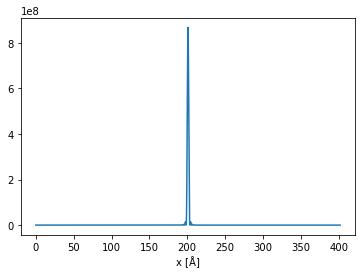

In [6]:
probe.profile().show()

In [7]:
detector = PixelatedDetector(max_angle='limit') 

In [8]:
measurement = wave.multislice(potential, pbar=True, potential_chunks=6, detector=detector)

(-25.0, 25.0)

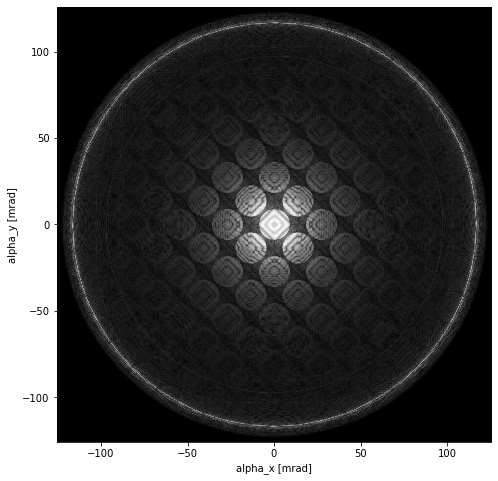

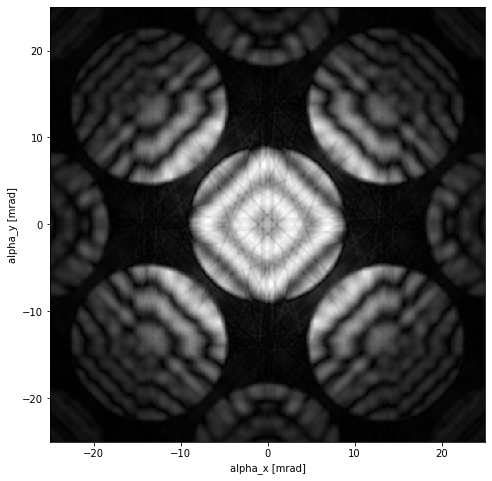

In [9]:
measurement = wave.diffraction_pattern('limit').mean(0)

ax, im = measurement.show(figsize=(8,8), power=.2)

ax, im = measurement.show(figsize=(8,8), power=.5)

ax.set_xlim([-25,25])
ax.set_ylim([-25,25])